# 164992_Fitting+MCMC

Using HD164992 dataset, we demonstrate how to

- perform a max-likelihood fit (with multiple telescopes)
- do an MCMC exploration of the posterior space (with multiple telescopes)


In [9]:
# Preliminary imports
#%pylab osx
%pylab inline
import radvel
import radvel.likelihood
from radvel.plot import orbit_plots
import copy
import pandas as pd
import os
from scipy import optimize
import corner
from astropy.time import Time
import numpy as np
from numpy import *
import copy

rcParams['font.size'] = 18

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [40]:
def bin_same_night(rv_data):
    # Convert time to Julian Date (JD) - round data to int
    rv_data['jd_date'] = rv_data['time'].apply(lambda x: int(np.floor(x)))

    # Group by JD and calculate mean values for each group
    rv_mean = rv_data.groupby('jd_date').agg({'mnvel': 'mean', 'errvel': 'mean'})

    # Get the number of observations per JD
    rv_size = rv_data.groupby('jd_date').size()

    # Calculate the adjusted error for velocity
    rv_mean['errvel'] = rv_mean['errvel'] / np.sqrt(rv_size)

    # Reset the index to make julian_date a column
    rv_mean.reset_index(inplace=True)

    return rv_mean

In [41]:
'''def bin_same_night(rv):
    rv['jd_date'] = rv['time'].apply(lambda x: int(np.floor(x)))
    rv_mean = rv.groupby('jd_date',as_index=False).mean()
    rv_n = rv.groupby('jd_date').size()
    rv_mean['errvel'] = rv_mean['errvel'] / np.array(np.sqrt(rv_n))
    return rv_mean'''

path = os.path.join(radvel.DATADIR,'164922_fixed.txt')
data = pd.read_csv(path, usecols=(0,1,2,3), delim_whitespace=True)

rv_hires_rk = data.query("tel == 'k'")
rv_hires_rj = data.query("tel == 'j'")
rv_apf = data.query("tel == 'a'")

rv_hires_rj = bin_same_night(rv_hires_rj)
rv_hires_rk = bin_same_night(rv_hires_rk)
rv_apf = bin_same_night(rv_apf)

t_start = min(data['time'].values)
t_stop = max(data['time'].values)
ti = linspace(t_start,t_stop,10000)

           time      mnvel    errvel tel
0  2.450276e+06  10.865899  1.142249   k
1  2.450603e+06   4.652810  1.027777   k
2  2.450667e+06   4.533556  0.909897   k
3  2.450956e+06  -3.697117  1.058852   k
4  2.450983e+06  -7.498180  1.092793   k
               time       mnvel      errvel
count  4.010000e+02  401.000000  401.000000
mean   2.455474e+06   -1.645329    1.268805
std    1.720067e+03    5.770581    0.426505
min    2.450276e+06  -16.250306    0.798408
25%    2.454280e+06   -6.130621    1.020333
50%    2.455904e+06   -2.103442    1.101166
75%    2.457059e+06    2.443365    1.255647
max    2.457293e+06   15.221989    2.966160


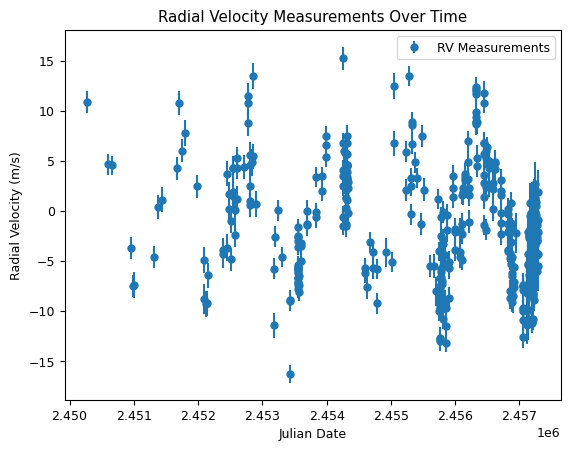

Empty DataFrame
Columns: [time, mnvel, errvel, tel]
Index: []


In [32]:
# Display the first few rows of the data to understand its structure
print(data.head())

# Basic Statistics
print(data.describe())

# Plotting the radial velocity measurements
plt.errorbar(data['time'], data['mnvel'], yerr=data['errvel'], fmt='o', label='RV Measurements')
plt.xlabel('Julian Date')
plt.ylabel('Radial Velocity (m/s)')
plt.title('Radial Velocity Measurements Over Time')
plt.legend()
plt.show()

# If you want to see data from a specific telescope
tel_data = data[data['tel'] == 'SpecificTelCode']  # Replace 'SpecificTelCode' with actual telescope code
print(tel_data.head())

In [42]:
#Some conveinence functions
def initialize_model():
    time_base = 2456778
    params = radvel.Parameters(2,basis='per tc secosw sesinw logk')
    params['per1'] = radvel.Parameter(value=1201.1 + 0.4)
    params['tc1'] = radvel.Parameter(value=2456778 + 1)
    params['secosw1'] = radvel.Parameter(value=0.01)
    params['sesinw1'] = radvel.Parameter(value=0.01)
    params['logk1'] = radvel.Parameter(value=1)
    params['per2'] = radvel.Parameter(value=75.765 + 0.1)
    params['tc2'] = radvel.Parameter(value=2456277.6)
    params['secosw2'] = radvel.Parameter(value=0.01)
    params['sesinw2'] = radvel.Parameter(value=0.01)
    params['logk2'] = radvel.Parameter(value=1)
    params['dvdt'] = radvel.Parameter(value=0)
    params['curv'] = radvel.Parameter(value=0)
    mod = radvel.RVModel(params, time_base=time_base)
    return mod


# Max-likelihood fitting

1. Initialize model
2. Build up likelihoods
3. Instantiate posterior
4. Perform fit

Setting vary=False and linear=True on the gamma parameters will cause them to be solved for analytically following the technique described [here](http://cadence.caltech.edu/~bfulton/share/Marginalizing_the_likelihood.pdf) (Thanks Tim Brandt!). If you use this you will need to calculate the uncertainties on the gammas manually following that derivation.

In [43]:
def initialize_likelihood(rv,suffix):
    like = radvel.likelihood.RVLikelihood( 
        mod, rv.time, rv.mnvel, rv.errvel,suffix=suffix)
    return like
mod = initialize_model()

# Build up HIRES >2004 likelihood
like_hires_rj = initialize_likelihood(rv_hires_rj,'_hires_rj')
like_hires_rj.params['gamma_hires_rj'] = radvel.Parameter(value=1.0, vary=False, linear=True)
like_hires_rj.params['jit_hires_rj'] = radvel.Parameter(value=np.log(1))

# Build up HIRES <2004 likelihood
like_hires_rk = initialize_likelihood(rv_hires_rk,'_hires_rk')
like_hires_rk.params['gamma_hires_rk'] = radvel.Parameter(value=1.0, vary=False, linear=True)
like_hires_rk.params['jit_hires_rk'] = radvel.Parameter(value=np.log(1))

# Build up APF
like_apf = initialize_likelihood(rv_apf,'_apf')
like_apf.params['gamma_apf'] = radvel.Parameter(value=1.0, vary=False, linear=True)
like_apf.params['jit_apf'] = radvel.Parameter(value=np.log(1))

# Build composite likelihood
like = radvel.likelihood.CompositeLikelihood(
    [like_hires_rj,like_hires_rk,like_apf])

# Set initial values for jitter
like.params['jit_hires_rk'] = radvel.Parameter(value=log(2.6))
like.params['jit_hires_rj'] = radvel.Parameter(value=log(2.6))
like.params['jit_apf'] = radvel.Parameter(value=log(2.6))

# Do not vary dvdt or jitter (Fulton 2015)
like.params['dvdt'].vary = False
like.params['curv'].vary = False
like.params['jit_hires_rk'].vary = False
like.params['jit_hires_rj'].vary = False
like.params['jit_apf'].vary = False

AttributeError: 'DataFrame' object has no attribute 'time'

In [44]:
# Instantiate posterior
post = radvel.posterior.Posterior(like)
post0 = copy.deepcopy(post)

# Add in priors
post.priors += [radvel.prior.EccentricityPrior( 2 )] # Keeps eccentricity < 1

# Perform Max-likelihood fitting
res  = optimize.minimize(
    post.neglogprob_array,
    post.get_vary_params(), 
    method='Powell',
    options=dict(maxiter=100000,maxfev=100000,xtol=1e-8)
    )

print("Initial loglikelihood = %f" % post0.logprob())
print("Final loglikelihood = %f" % post.logprob())
print(post)

Initial loglikelihood = -1312.406677
Final loglikelihood = -1312.358160
parameter                     value      vary
per1                        1196.11       True
tc1                        -8.63094       True
secosw1                   -0.237151       True
sesinw1                    0.189349       True
logk1                       1.97501       True
per2                        75.7342       True
tc2                        -498.153       True
secosw2                   -0.263113       True
sesinw2                    0.430093       True
logk2                      0.741008       True
dvdt                              0      False
curv                              0      False
gamma_hires_rj             0.169566      False
jit_hires_rj               0.955511      False
gamma_hires_rk             0.240148      False
jit_hires_rk               0.955511      False
gamma_apf                  0.970504      False
jit_apf                    0.955511      False
tp1                          135.89 

# Perform MCMC posterior exploration

In [36]:
df = radvel.mcmc(post, nrun=200, savename='rawchains.h5')

20000/80000 (25.0%) steps complete; Running 4834.42 steps/s; Mean acceptance rate = 45.8%; Min Auto Factor =  18; Max Auto Relative-Change =   inf; Min Tz = 3109.2; Max G-R = 1.009
Discarding burn-in now that the chains are marginally well-mixed

80000/80000 (100.0%) steps complete; Running 7300.66 steps/s; Mean acceptance rate = 40.5%; Min Auto Factor =  22; Max Auto Relative-Change = 0.457; Min Tz = 3827.1; Max G-R = 1.007

MCMC: WARNING: chains did not pass convergence tests. They are likely not well-mixed.


In [37]:
df_synth = post.params.basis.to_synth(df)
labels = 'per1 tc1 e1 k1 per2 tc2 e2 k2 '.split()
df_synth[labels].quantile([0.14,0.5,0.84]).T

,0.14,0.50,0.84
per1,1.195227e+03,1.196135e+03,1.196971e+03
tc1,2.456767e+06,2.456770e+06,2.456772e+06
e1,7.984989e-02,9.472679e-02,1.095344e-01
k1,7.050397e+00,7.200073e+00,7.344230e+00
per2,7.571555e+01,7.573497e+01,7.575750e+01
tc2,2.456278e+06,2.456280e+06,2.456281e+06
e2,1.612439e-01,2.387809e-01,3.215964e-01
k2,1.921157e+00,2.075000e+00,2.231323e+00


Compare with parameters from fulton et al. (2016)
---------

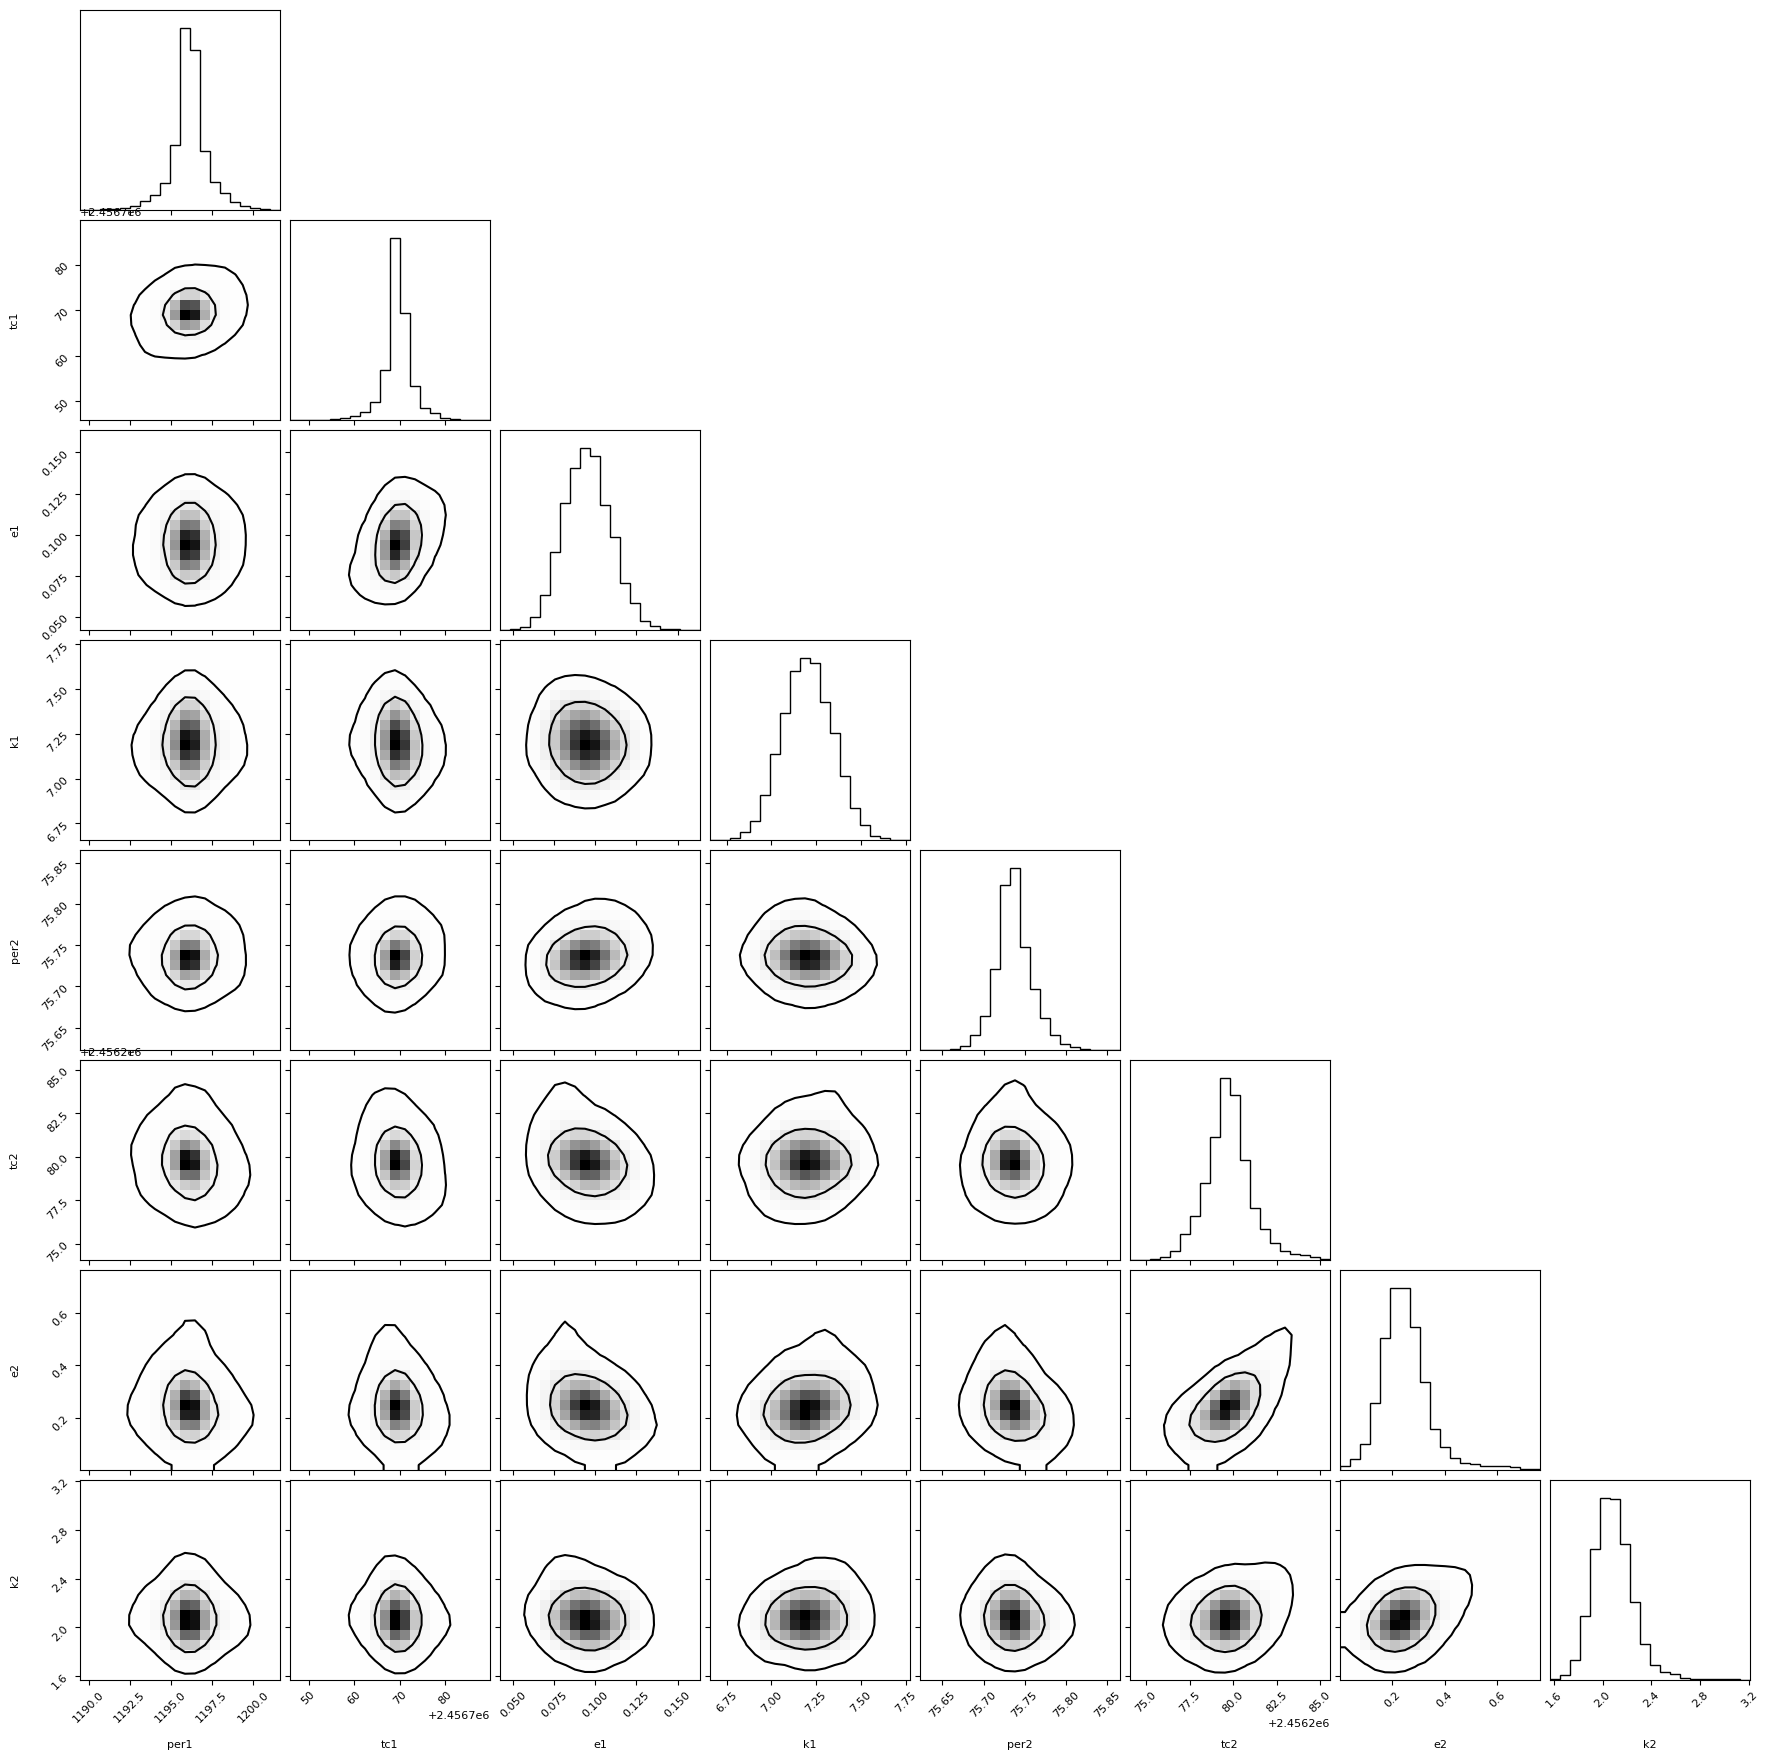

In [38]:
labels = 'per1 tc1 e1 k1 per2 tc2 e2 k2'.split()
rc('font',size=8)

fig = corner.corner(
    df_synth[labels],labels=labels,
    levels=[0.68,0.95],plot_datapoints=False,smooth=True,bins=20
    )

(<Figure size 750x1092.86 with 5 Axes>,
 [<Axes: ylabel='RV [m s$^{\\mathregular{-1}}$]'>,
  <Axes: xlabel='JD - 2450000', ylabel='Residuals'>,
  <Axes: xlabel='Phase', ylabel='RV [m s$^{\\mathregular{-1}}$]'>,
  <Axes: xlabel='Phase', ylabel='RV [m s$^{\\mathregular{-1}}$]'>])

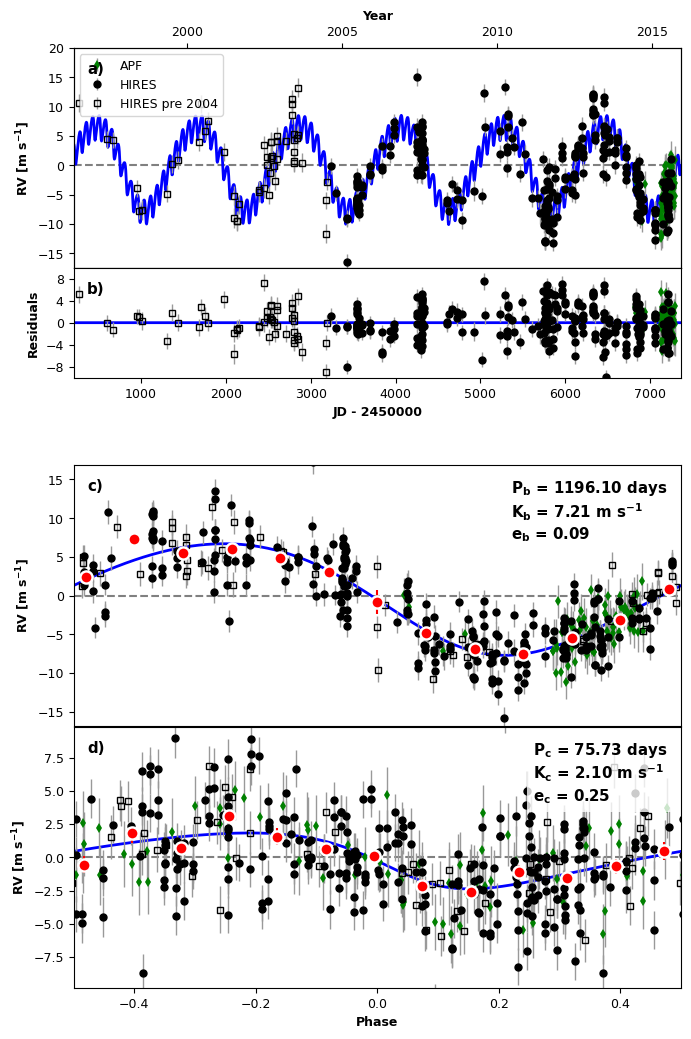

In [39]:
RVPlot = orbit_plots.MultipanelPlot(post)
RVPlot.plot_multipanel()